# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [6]:
%pip install pyrosm keplergl haversine pandas numpy

  Using cached pyrosm-0.6.2.tar.gz (2.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached haversine-2.8.0-py2.py3-none-any.whl (7.7 kB)
  Using cached cykhash-2.0.1.tar.gz (44 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 632.3 kB/s eta 0:00:0000:0100:01
  Using cached pyrobuf-0.9.3-cp39-cp39-macosx_10_9_x86_64.whl


  Created wheel for pyrosm: filename=pyrosm-0.6.2-cp39-cp39-macosx_10_9_x86_64.whl size=2716321 sha256=9fcfe1457e30f080a9872a1a1525854e946e45c332d4b289406f98cbf00636d2
  Stored in directory: /Users/hamidreza/Library/Caches/pip/wheels/e7/60/b4/9103ec8817e936dc79720d9673cd29876b62620e288e734388
  Created wheel for cykhash: filename=cykhash-2.0.1-cp39-cp39-macosx_10_9_x86_64.whl size=623851 sha256=45f58cd904e360b8647ba959a3cc3f4e2fe9a00e97b2219b86034d28e41925f8
  Stored in directory: /Users/hamidreza/Library/Caches/pip/wheels/c1/fc/84/88e9b54ebff42d5d236d19bb1c5d12026565c8a133790f08c2
Successfully built pyrosm cykhash
Note: you may need to restart the kernel to use updated packages.


In [7]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time

from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [3]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google.colab'

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [8]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [9]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [10]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [11]:
# Visualize pasdaran_streets using kepler
!pip install keplergl pandas

In [29]:
map_streets = KeplerGl()
map_streets.add_data(data=pasdaran_streets, name='streets')
map_streets.save_to_html(file_name='pasdaran_streets_map.html')


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to pasdaran_streets_map.html!


# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [25]:
def find_shortest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    distances = {node_id: float('inf') for node_id in graph['u'].append(graph['v']).unique()}
    previous_node = {node_id: None for node_id in graph['u'].append(graph['v']).unique()}
#     start_node_id = graph[(graph['u_lat'] == start_node[0]) & (graph['u_lon'] == start_node[1])]['u'].values
#     end_node_id = graph[(graph['v_lat'] == end_node[0]) & (graph['v_lon'] == end_node[1])]['v'].values
    start_node_id = start_node
    end_node_id = end_node
    distances[start_node_id] = 0
    visited_nodes = set()
    while end_node_id not in visited_nodes:
        current_node = min((node_id for node_id in set(distances.keys()) - visited_nodes), key=distances.get)
        visited_nodes.add(current_node)
        for _, row in graph.iterrows():
            if row['u'] == current_node:
                neighbor = row['v']
            elif row['v'] == current_node:
                neighbor = row['u']
            else:
                continue

            new_distance = distances[current_node] + row['length']

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                previous_node[neighbor] = current_node

                
    path = []
    current_node = end_node_id
    while current_node is not None:
        path.insert(0, current_node)
        current_node = previous_node[current_node]

    return path

In [26]:
import networkx as nx

def shortest_path_networkx(start_node,end_node,graph):
    G = nx.DiGraph()
    for _, row in graph.iterrows():
        G.add_edge(row['u'], row['v'], weight=row['length'])
        G.add_edge(row['v'], row['u'], weight=row['length'])

    start_node_id = start_node
    end_node_id = end_node
    shortest_path = nx.shortest_path(G, source=start_node_id, target=end_node_id, weight='weight')

    return shortest_path

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [27]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

# TODO: Implement and print out a sample trip
set1 = set (pasdaran_streets['v'])
set2 = set (pasdaran_streets['u'])

nodes = set1.union(set2)

In [40]:
import random


start_node = random.choice(list(nodes))
end_node = random.choice(list(nodes))
print(start_node,end_node )

# A trip is a list of node_ids from start_node to end_node.
scratch_trip = find_shortest_path(start_node, end_node, pasdaran_streets)
print("shortest path from scratch")
print(scratch_trip)
nx_trip = shortest_path_networkx(start_node, end_node, pasdaran_streets)
print("shortest path with networkx")
print(nx_trip)

4695529119 4695735787


/var/folders/w_/ktm169bx72l270xpfjd5sljh0000gn/T/ipykernel_27174/1693435415.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances = {node_id: float('inf') for node_id in graph['u'].append(graph['v']).unique()}
/var/folders/w_/ktm169bx72l270xpfjd5sljh0000gn/T/ipykernel_27174/1693435415.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  previous_node = {node_id: None for node_id in graph['u'].append(graph['v']).unique()}


shortest path from scratch
[4695529119, 4695567371, 4664780472, 4695567369, 9751562375, 9441587469, 1725415333, 1725415336, 9900349188, 9441587429, 9900349189, 9900349190, 9900349193, 9900349191, 9847389529, 9569441693, 4412258444, 4695567367, 3405484850, 4412258440, 3405484852, 4692533035, 3405484865, 423816747, 4695737210, 4695737204, 4695737198, 4695737196, 4695737194, 4695737195, 4695735788, 4695735787]
shortest path with networkx
[4695529119, 4695567371, 4664780472, 4695567369, 9751562375, 9441587469, 1725415333, 1725415336, 9900349188, 9441587429, 9900349189, 9900349190, 9900349193, 9900349191, 9847389529, 9569441693, 4412258444, 4695567367, 3405484850, 4412258440, 3405484852, 4692533035, 3405484865, 423816747, 4695737210, 4695737204, 4695737198, 4695737196, 4695737194, 4695737195, 4695735788, 4695735787]


In [44]:
#convert trip to df
trip_df = []
for i in range(len(scratch_trip)):
    for _, row in pasdaran_nodes.iterrows():
        if row['id'] == scratch_trip[i]:
            trip_df.append(row)
            break

trip_df = pd.DataFrame(trip_df)

Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [45]:
#TODO: Visualize the sampled trip using kepler
map_trip = KeplerGl()
map_trip.add_data(data=trip_df, name='trip')
map_trip.save_to_html(file_name='trip_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to trip_map.html!


Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [187]:
def trip_details(trip):
    lats = []
    lons = []
    lengths = []
    for i in range(len(trip)-1):
        street = pasdaran_streets.loc[((pasdaran_streets['v'] == trip[i]) & (pasdaran_streets['u'] == trip[i+1])) | ((pasdaran_streets['u'] == trip[i]) & (pasdaran_streets['v'] == trip[i+1]))].head(1)
        if i == 0:
            if street['u'].values[0] == trip[0]:
                lats.append(street['u_lat'].values[0])
                lons.append(street['u_lon'].values[0])
                lats.append(street['v_lat'].values[0])
                lons.append(street['v_lon'].values[0])
            else:
                lats.append(street['v_lat'].values[0])
                lons.append(street['v_lon'].values[0])
                lats.append(street['u_lat'].values[0])
                lons.append(street['u_lon'].values[0])
        else:
            if street['u_lat'].values[0] == lats[i] and street['u_lon'].values[0] == lons[i]:
                lats.append(street['v_lat'].values[0])
                lons.append(street['v_lon'].values[0])
            else:
                lats.append(street['u_lat'].values[0])
                lons.append(street['u_lon'].values[0])
        lengths.append(street['length'].values[0])
    return lats, lons, lengths

In [188]:
def calculate_current_loc(previous_loc, ride_speed, ride_gps_time, lats, lons, starting_index):
    length = ((previous_loc[0]-lats[starting_index+1])**2 + (previous_loc[1]-lons[starting_index+1])**2)**0.5
    movement = ride_speed*ride_gps_time
    indices_to_go = 0
#     print(length)
#     print(movement)
#     print(previous_loc)
    while length < movement:
        indices_to_go += 1
        if starting_index + indices_to_go == len(lats) - 1:
            return indices_to_go, [lats[-1], lons[-1]]
        movement -= length
        length = ((lats[starting_index+indices_to_go]-lats[starting_index+indices_to_go+1])**2 + (lons[starting_index+indices_to_go]-lons[starting_index+indices_to_go+1])**2)**0.5
    next_loc = []
    if indices_to_go == 0:
        next_loc = [previous_loc[0] + movement*(lats[starting_index+1]-previous_loc[0])/length, previous_loc[1] + movement*(lons[starting_index+1]-previous_loc[1])/length]
    else:
        next_loc = [lats[starting_index+indices_to_go] + movement*(lats[starting_index+indices_to_go+1]-lats[starting_index+indices_to_go])/length, lons[starting_index+indices_to_go] + movement*(lons[starting_index+indices_to_go+1]-lons[starting_index+indices_to_go])/length]
        
    return indices_to_go, next_loc
        

In [189]:
#TODO
def visualize_a_ride(ride_speed, ride_gps_time, trip):
    lats, lons, _= trip_details(trip)
    starting_index = 0
    time = 0
    ride = []
    ride.append([lats[0], lons[0]])
    while starting_index != len(trip) - 1:
#         print(starting_index)
        indices_to_go, next_loc = calculate_current_loc(ride[-1], ride_speed, ride_gps_time, lats, lons, starting_index)
#         print(next_loc)
        ride.append(next_loc)
        time += ride_gps_time
        starting_index += indices_to_go
    return ride
        

See a sample ride, printed out.

In [190]:
lats, lons, lengths = trip_details(scratch_trip)
print(lats)
print(lons)
print(lengths)
# print(scratch_trip[0])
# street = pasdaran_streets.loc[((pasdaran_streets['v'] == scratch_trip[0]) & (pasdaran_streets['u'] == scratch_trip[1])) | ((pasdaran_streets['u'] == scratch_trip[0]) & (pasdaran_streets['v'] == scratch_trip[1]))].head(1)
# print(street['v'].values[0])

[35.76219940185547, 35.76223373413086, 35.762550354003906, 35.76288604736328, 35.76299285888672, 35.76324462890625, 35.76333999633789, 35.7636604309082, 35.76377487182617, 35.76381301879883, 35.763797760009766, 35.76380157470703, 35.76381301879883, 35.76383590698242, 35.76389694213867, 35.76393508911133, 35.76483154296875, 35.765316009521484, 35.76616668701172, 35.766475677490234, 35.766727447509766, 35.766700744628906, 35.7667350769043, 35.766990661621094, 35.7673225402832, 35.76761245727539, 35.76797866821289, 35.768043518066406, 35.768428802490234, 35.76858139038086, 35.76847839355469, 35.76810073852539]
[51.45186614990234, 51.45110702514648, 51.45111846923828, 51.45112609863281, 51.45107650756836, 51.45101547241211, 51.45099258422852, 51.45094680786133, 51.45093536376953, 51.450931549072266, 51.45087814331055, 51.4508171081543, 51.45075988769531, 51.450714111328125, 51.45068359375, 51.4507064819336, 51.45121765136719, 51.45149230957031, 51.44985961914063, 51.44917297363281, 51.4484

In [192]:
#TODO
ride = visualize_a_ride(0.0005, 1, scratch_trip)
print(ride)

[[35.76219940185547, 51.45186614990234], [35.7622219918298, 51.45136666046996], [35.762473676730586, 51.45111569777057], [35.762965403945536, 51.451089254505334], [35.76345145680638, 51.45097666130445], [35.763805273117505, 51.45079861610194], [35.76419274405677, 51.4508534000727], [35.76462709292753, 51.451101071343686], [35.765061766386175, 51.45134817172982], [35.765412000482236, 51.45130807579811], [35.765643035602274, 51.45086465413275], [35.76587407072231, 51.45042123246739], [35.76610510584234, 51.44997781080203], [35.766317179100916, 51.44952519227574], [35.76651464970794, 51.44906609527818], [35.76668593793195, 51.44859635030022], [35.766713994992585, 51.44810392115849], [35.76672998195611, 51.44760757157377], [35.76696084165707, 51.44716485667335], [35.76714065353073, 51.446698899716786], [35.76731231695711, 51.44622929172277], [35.76776089923344, 51.446031217810656], [35.76822817146232, 51.4458533780076], [35.76854911252741, 51.44560232047811], [35.768264005085896, 51.445429

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [193]:
#TODO: Visualize the sampled ride using kepler
ride_df = pd.DataFrame(ride, columns=['lat', 'lon'])
map_ride = KeplerGl()
map_ride.add_data(data=ride_df, name='ride')
map_ride.save_to_html(file_name='ride_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ride_map.html!


Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [208]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
# TODO
# Print out a sample
def put_noise_normal(ride, gps_noise_radius):
    noise_lat = np.random.normal(0, gps_noise_radius, len(ride))
    noise_lon = np.random.normal(0, gps_noise_radius, len(ride))
    noisy_ride = []
    for i in range(len(ride)):
        noisy_ride.append([ride[i][0] + noise_lat[i], ride[i][1] + noise_lon[i]])
    return noisy_ride
noisy_ride_normal = put_noise_normal(ride, 0.0002)
print(noisy_ride_normal)

[[35.76213231620898, 51.45186067734206], [35.76215738492399, 51.451479831676906], [35.76241658282654, 51.45115868610336], [35.76276054852419, 51.450902228074604], [35.76347490402466, 51.4511069049567], [35.7638419566483, 51.45037066020229], [35.76402392375561, 51.45054814513422], [35.76460941821581, 51.4510394246452], [35.76495950834631, 51.45152158973675], [35.765058824242175, 51.451221076378246], [35.76578581285263, 51.450651626610586], [35.76584616150351, 51.45050836104812], [35.76628254150943, 51.450032702643675], [35.765891490824416, 51.44945765580814], [35.76642820756103, 51.44884753792059], [35.766601290335075, 51.44840924616214], [35.766654520788, 51.44791726532063], [35.76673943928129, 51.44775711729469], [35.76687743306244, 51.44686308568729], [35.76710563966188, 51.446868491177455], [35.7669548572003, 51.44612788994769], [35.76796075528116, 51.445642933151206], [35.7681116828562, 51.44566868748801], [35.768505535843985, 51.44539771657202], [35.76855032905724, 51.445236579627

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [209]:
#TODO: Experimenting with different GPS noise radiuses
def put_noise_uniform(ride, gps_noise_radius):
    noise_lat = np.random.uniform(-gps_noise_radius, gps_noise_radius, len(ride))
    noise_lon = np.random.uniform(-gps_noise_radius, gps_noise_radius, len(ride))
    noisy_ride = []
    for i in range(len(ride)):
        noisy_ride.append([ride[i][0] + noise_lat[i], ride[i][1] + noise_lon[i]])
    return noisy_ride
noisy_ride_uniform = put_noise_uniform(ride, 0.0002)
print(noisy_ride_uniform)
def put_noise_exp(ride, gps_noise_radius):
    noise_lat = np.random.exponential(gps_noise_radius, len(ride))
    noise_lon = np.random.exponential(gps_noise_radius, len(ride))
    noisy_ride = []
    for i in range(len(ride)):
        noisy_ride.append([ride[i][0] + noise_lat[i], ride[i][1] + noise_lon[i]])
    return noisy_ride
noisy_ride_exp = put_noise_exp(ride, 0.0002)
print(noisy_ride_exp)

[[35.76205962253485, 51.451878863721866], [35.762040239586504, 51.45136592923818], [35.762436483299965, 51.45126839777511], [35.762864288983295, 51.450896420040365], [35.76331678313231, 51.450816750771956], [35.76373000767578, 51.45067752260169], [35.76417736302827, 51.45077711229757], [35.764767601448746, 51.45092202577362], [35.76487763800226, 51.45129976668104], [35.76546826998888, 51.451480108891694], [35.765695691201365, 51.45080136434171], [35.76592248531455, 51.450562100055464], [35.7661289391747, 51.44990554046293], [35.7664831007969, 51.449590226152566], [35.76667073129093, 51.44910788116714], [35.766814096906266, 51.44847728347407], [35.76691148905053, 51.447913193957305], [35.766839076938076, 51.447496130064735], [35.7670521287269, 51.447117985195504], [35.76706648797425, 51.44677076937135], [35.767363825153275, 51.44633049785994], [35.76759001055273, 51.446049261972384], [35.768279143259726, 51.44599132655189], [35.768415378906106, 51.445746532152945], [35.76816857903269, 5

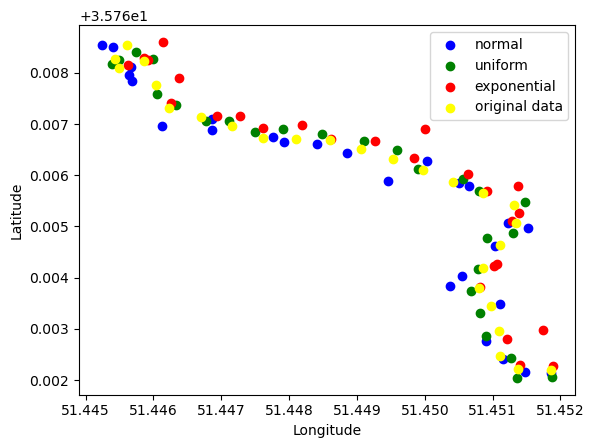

In [210]:
#TODO: Visualize the noise models using matplotlib
import matplotlib.pyplot as plt

lat_nor, lon_nor = zip(*noisy_ride_normal)
lat_uni, lon_uni = zip(*noisy_ride_uniform)
lat_exp, lon_exp = zip(*noisy_ride_exp)
lat, lon = zip(*ride)

# Plot the locations using scatter
plt.scatter(lon_nor, lat_nor, label='normal', color='blue')
plt.scatter(lon_uni, lat_uni, label='uniform', color='green')
plt.scatter(lon_exp, lat_exp, label='exponential', color='red')
plt.scatter(lon, lat, label='original data', color='yellow')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

In [211]:
#TODO: Visualize the noise models using kepler
ride_df = pd.DataFrame(ride, columns=['lat', 'lon'])
ride_nor_df = pd.DataFrame(noisy_ride_normal, columns=['lat', 'lon'])
map_ride_noise_normal = KeplerGl()
map_ride_noise_normal.add_data(data=ride_df, name='ride')
map_ride_noise_normal.add_data(data=ride_nor_df, name='normal')
map_ride_noise_normal.save_to_html(file_name='ride_noise_normal_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ride_noise_normal_map.html!


In [212]:
ride_uni_df = pd.DataFrame(noisy_ride_uniform, columns=['lat', 'lon'])
map_ride_noise_uniform = KeplerGl()
map_ride_noise_uniform.add_data(data=ride_df, name='ride')
map_ride_noise_uniform.add_data(data=ride_uni_df, name='uniform')
map_ride_noise_uniform.save_to_html(file_name='ride_noise_uniform_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ride_noise_uniform_map.html!


In [213]:
ride_exp_df = pd.DataFrame(noisy_ride_exp, columns=['lat', 'lon'])
map_ride_noise_exp = KeplerGl()
map_ride_noise_exp.add_data(data=ride_df, name='ride')
map_ride_noise_exp.add_data(data=ride_exp_df, name='exponential')
map_ride_noise_exp.save_to_html(file_name='ride_noise_exp_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ride_noise_exp_map.html!


#TODO: Choose the best model (while you explain why you chose it)
بهترین انتخاب نرمال است چون به احتمال بالاتر خطا برابر ۰ است و به احتمال کمتری خطا وجود دارد. همچنین معمولا در مثال ها نمودار نرمال بهتر جواب میدهد و در طبیعت هم در تعداد بالا تمام نمودار ها به نرمال میل میکنند. همچنین در نمودار نمایی ما فقط خطای مثبت داریم که خوب نیست. در نمودار یونیفرم هم به احتمال تمام خطا ها یکی است که خوب نیست.

**Explanation of my noise model:**

...

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

#TODO: Visualize using kepler
در قسمت های قبل انجام شد

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [214]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it
noisy_rides = []
original_rides = []
for i in range(20):
    start_node = random.choice(list(nodes))
    end_node = random.choice(list(nodes))
    trip_tmp = find_shortest_path(start_node, end_node, pasdaran_streets)
    print(trip_tmp)
    ride_tmp = visualize_a_ride(0.0005, 1, trip_tmp)
#     print(ride_tmp)
    print("++++++++++++++++++++++++++")
    noisy_ride_tmp = put_noise_normal(ride_tmp, 0.0002)
    original_rides.append(ride_tmp)
    noisy_rides.append(noisy_ride_tmp)
print(noisy_rides)
print("======================")
print(original_rides)

/var/folders/w_/ktm169bx72l270xpfjd5sljh0000gn/T/ipykernel_27174/1693435415.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distances = {node_id: float('inf') for node_id in graph['u'].append(graph['v']).unique()}
/var/folders/w_/ktm169bx72l270xpfjd5sljh0000gn/T/ipykernel_27174/1693435415.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  previous_node = {node_id: None for node_id in graph['u'].append(graph['v']).unique()}


[423793590, 423833951, 4429692925, 423832943, 4482481112, 423832942, 423832817, 423832941, 1707151179, 423833040, 4657965378, 423833041, 423833042, 4696632873, 4698562496, 6089414139]
++++++++++++++++++++++++++
[4698367362, 4698367361, 4698367363, 423816890, 423815710, 4698380304, 4698380301, 423815709, 4548912086, 4548912079, 423813731, 987522525, 423815705, 987522495, 423815704, 4695818007, 987522473, 423813741, 423816751, 9645503552, 423815702, 3405484867, 423815701, 4695735782, 423815687, 1762129786, 4695666775, 4695737209, 3405484866, 3405484864, 1762129778, 423816408, 4752577815, 4695666785, 5258869797, 423816409, 5244624163, 1725415355, 5254232803, 5257384708, 4695818020, 423793628, 1864300666, 1864300712, 3405485396, 1864300721, 4998084444, 4998084446, 9512321115, 33238927, 4450941429, 7266382968, 7266382969, 7710025071]
++++++++++++++++++++++++++
[423816409, 4695667391, 4695666779, 4695667389, 4379726016, 4695667393, 806589358, 4695818010, 4695818011, 423832591, 4879764419, 10

[4695818017, 4695818018, 4695818016, 4695818013, 4879764419, 4695882304, 4695882301, 4695924450, 1864300705, 4695924446, 4695924443, 4695924442, 4695924436, 4695924430, 423793625, 4695924423, 4695924416, 4695924415]
++++++++++++++++++++++++++
[[[35.77418736946496, 51.46358398962238], [35.77498465548881, 51.46383163996753], [35.77482540562245, 51.46390345833578], [35.775282288587086, 51.46358514276695], [35.775493929870656, 51.46365657295441], [35.77623223019798, 51.46349412308807], [35.776498291698815, 51.463706643827116], [35.776967981915696, 51.46340188441027], [35.77718549199423, 51.46386870124209], [35.77759900589916, 51.46410483835041], [35.777821588616135, 51.46434723927251], [35.77818253831961, 51.46521511834161], [35.77887629382046, 51.46520854287828], [35.779338918991634, 51.46492270396085], [35.77960322976586, 51.46502640985126]], [[35.774754587950675, 51.44115530849192], [35.77484183254084, 51.44118071919839], [35.7739246493616, 51.441012677496], [35.773950650905064, 51.4412

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [331]:
#TODO: Implement helper functions for your calculations
from scipy.stats import norm

def calculate_distance(lat1, lon1, lat2, lon2):
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5

def find_near_streets(loc, threshold): 
    near_streets = []
    min_dis = float('inf')
    nearest_street = None
    for _, row in pasdaran_streets.iterrows():
        dis = calculate_distance(loc[0], loc[1], (row['u_lat']+row['v_lat'])/2, (row['u_lon']+row['v_lon'])/2)
        if dis < threshold:
            near_streets.append(row)
            if dis < min_dis:
                min_dis = dis
                nearest_street = row['street_id']
    return near_streets, nearest_street
    
def create_adjacent_table():
    adjacent_table = np.zeros((len(pasdaran_streets), len(pasdaran_streets)))
    for i in range(len(pasdaran_streets)):
        print(i)
        for j in range(i+1, len(pasdaran_streets)):
#             if pasdaran_streets.iloc[i]['u'] == pasdaran_streets.iloc[j]['u'] | pasdaran_streets.iloc[i]['u'] == pasdaran_streets.iloc[j]['v'] | pasdaran_streets.iloc[i]['v'] == pasdaran_streets.iloc[j]['u'] | pasdaran_streets.iloc[i]['v'] == pasdaran_streets.iloc[j]['v']:
              if abs(pasdaran_streets.iloc[i]['v_lat'] + pasdaran_streets.iloc[i]['u_lat'] - pasdaran_streets.iloc[j]['v_lat'] - pasdaran_streets.iloc[j]['u_lat']) < 0.006:
                if abs(pasdaran_streets.iloc[i]['v_lon'] + pasdaran_streets.iloc[i]['u_lon'] - pasdaran_streets.iloc[j]['v_lon'] - pasdaran_streets.iloc[j]['u_lon']) < 0.006:
    
                    adjacent_table[i,j] = 1
                    adjacent_table[j,i] = 1
                    
    return adjacent_table

def emission (noisy_point, observed_street, standard_deviation):
    dis = calculate_distance(noisy_point[0], noisy_point[1], (observed_street['u_lat']+observed_street['v_lat'])/2, (observed_street['u_lon']+observed_street['v_lon'])/2)
    z_score = dis / standard_deviation

    prob = norm.cdf(z_score)
    return prob



def transition(next_street, observed_street, standard_deviation):
    distance = calculate_distance((observed_street['u_lat']+observed_street['v_lat'])/2, (observed_street['u_lon']+observed_street['v_lon'])/2, (next_street['u_lat']+next_street['v_lat'])/2, (next_street['u_lon']+next_street['v_lon'])/2)
    z_score = distance / standard_deviation
    prob = norm.cdf(z_score)
    return prob
        
        
        

In [332]:
# Define your HMM model
# Hint: You can assume states of your HMM model to be streets of the map. You may use other designs as well (based on your creativity)!

def HMM(noisy_ride):
    transition_matrix = np.zeros((len(pasdaran_streets), len(pasdaran_streets)))
    emission_matrix = np.zeros((len(noisy_ride), len(pasdaran_streets)))
    for t in range(len(noisy_ride)):
        for s in range(len(pasdaran_streets)):
            emission_matrix[t, s] = emission(noisy_ride[t], pasdaran_streets.iloc[s], 0.002)
        print(t)
    print("emission finished")
    adjacent_table = create_adjacent_table()
    for t in range(len(pasdaran_streets)):
        for s in range(len(pasdaran_streets)):
            if adjacent_table[s,t] == 0:
                transition_matrix[s,t] = 0
                continue
            transition_matrix[s,t] = transition(pasdaran_streets.iloc[s], pasdaran_streets.iloc[t], 0.002) 
        print(t)
        print(transition_matrix[t,:])
    return emission_matrix, transition_matrix

In [335]:
# Use Viterbi Algorithm to find the most probable set of points (denoised points)

def viterbi(noisy_ride):
    viterbi_matrix = np.zeros((len(noisy_ride), len(pasdaran_streets)))
    backpointer_matrix = np.zeros((len(noisy_ride), len(pasdaran_streets)), dtype=int)
    emission_matrix, transition_matrix = HMM(noisy_ride)
#     print(emission_matrix)
#     print(transition_matrix)
    for i in range(len(pasdaran_streets)):
#         print(i)
#         print(pasdaran_streets.iloc[i])
#         print(pasdaran_streets.iloc[i]['u_lat'])
        viterbi_matrix[0, i] = emission_matrix[0, i]
        if viterbi_matrix[0,i] != 0:
                print(0)
                print(i)
                print(viterbi_matrix[t, s])
                print(backpointer_matrix[t, s])
                print("=======================")
    
    for t in range(1, len(noisy_ride)):
        for s in range(len(pasdaran_streets)):
            max_prob = 0
            index = -1
            for k in range(len(pasdaran_streets)):
                tmp = viterbi_matrix[t-1, k] * transition_matrix[s, k]
                if tmp > max_prob:
                    max_prob = tmp
                    index = k
            viterbi_matrix[t, s] = max_prob * emission_matrix[t, s]
            backpointer_matrix[t, s] = index
            if viterbi_matrix[t,s] != 0:
                print(t)
                print(s)
                print(viterbi_matrix[t, s])
                print(backpointer_matrix[t, s])
                print("=======================")
            
    best_path_prob = np.max(viterbi_matrix[-1, :])
    best_last_state = np.argmax(viterbi_matrix[-1, :])
    best_path = [best_last_state]
    for t in range(len(noisy_ride) - 1, 0, -1):
        best_last_state = backpointer_matrix[t, best_last_state]
        best_path.insert(0, best_last_state)

    return best_path

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [336]:
#TODO: Visualize a sample noisy_ride alongside its denoised version
noisy_ride = noisy_rides[0]
original_ride = original_rides[0]
denoised_trip = viterbi(noisy_ride)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
emission finished
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
2

KeyboardInterrupt: 

In [ ]:
#convert trip to df
trip_df = []
for i in range(len(denoised_trip)):
    street = pasdaran_streets.iloc[denoised_trip[i]]
    trip_df.append([(street['u_lat']+street['v_lat'])/2, (street['u_lon']+street['v_lon'])/2])

print(trip_df)
print(noisy_ride)
denoised_trip_df = pd.DataFrame(trip_df, columns=['lat', 'lon'])
original_ride_df = pd.DataFrame(original_ride, columns=['lat', 'lon'])
noisy_ride_df = pd.DataFrame(noisy_ride, columns=['lat', 'lon'])

map_denoised_ride = KeplerGl()
map_denoised_ride.add_data(data=denoised_trip_df , name='denoised')
map_denoised_ride.add_data(data=original_ride_df , name='original')
map_denoised_ride.add_data(data=noisy_ride_df , name='noisy')
map_denoised_ride.save_to_html(file_name='ride_denoised_map.html')

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [ ]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    mean_haversine = 0
    for i in range(len(denoised_points)):
        mean_haversine += haversine(denoised_points[i], original_points[i])
    return mean_haversine / len(denoised_points)

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original

In [ ]:
test_dataset_noisy

In [ ]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
# This should be of order 10^-3
def calculate_mean_haversine(test_dataset_original, test_dataset_noisy):
    mean_haversine = 0
    for i in range(20):
        noisy_ride = []
        original_ride = []
        for j in range(len(test_dataset_noisy)):
            if test_dataset_noisy.iloc[j]['trip_id'] == i:
                noisy_ride.append([test_dataset_noisy.iloc[j]['lat'], test_dataset_noisy.iloc[j]['lon']])
                original_ride.append([test_dataset_original.iloc[j]['lat'], test_dataset_original.iloc[j]['lon']])
        denoised_trip = viterbi(noisy_ride)
        trip = []
        for i in range(len(denoised_trip)):
            street = pasdaran_streets.iloc[denoised_trip[i]]
            trip.append([(street['u_lat']+street['v_lat'])/2, (street['u_lon']+street['v_lon'])/2])

        mean_haversine += mean_haversine_distance(trip, original_ride)
    return mean_haversine / 20

print(calculate_mean_haversine(test_dataset_original, test_dataset_noisy))     
            

**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)